In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS

In [2]:
project_data=pd.read_csv('sentiment.csv')

In [3]:
project_data.shape

(13871, 21)

In [4]:
df=project_data[['text','sentiment']]

In [5]:
df.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [6]:

new_df = df[df.sentiment != 'Neutral']

In [7]:
new_df.shape

(10729, 2)

In [8]:
new_df.head(10)

,text,sentiment
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive
6,RT @warriorwoman91: I liked her and was happy ...,Negative
8,Deer in the headlights RT @lizzwinstead: Ben C...,Negative
9,RT @NancyOsborne180: Last night's debate prove...,Negative
10,@JGreenDC @realDonaldTrump In all fairness #Bi...,Negative
11,RT @WayneDupreeShow: Just woke up to tweet thi...,Positive
12,Me reading my family's comments about how grea...,Negative


In [9]:
new_df.describe()

,text,sentiment
count,10729,10729
unique,7784,2
top,RT @RWSurferGirl: Jeb Bush reminds me of eleva...,Negative
freq,159,8493


In [10]:
new_df["sentiment"]= new_df["sentiment"].replace("Positive", 1) 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
new_df["sentiment"]= new_df["sentiment"].replace("Negative", 0) 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
new_df.head()

,text,sentiment
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,1
3,RT @RobGeorge: That Carly Fiorina is trending ...,1
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,1
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",1
6,RT @warriorwoman91: I liked her and was happy ...,0


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_df['text'].values, 
                 new_df['sentiment'].values,        
                 test_size=0.2)

In [14]:
import re
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [15]:
vect = CountVectorizer(tokenizer=tokenize)
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

# naive bayes

In [16]:
p = tf_train[y_train==1].sum(0) + 1

In [17]:
q = tf_train[y_train==0].sum(0) + 1

In [18]:
r = np.log((p/p.sum()) / (q/q.sum()))

In [19]:
b = np.log(len(p) / len(q))

In [20]:
pre_preds = tf_test @ r.T + b
preds = pre_preds.T > 0
accuracy = (preds == y_test).mean()
print(accuracy)

0.8415657036346692


# logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train, y_train)
preds = model.predict(tf_test)
accuracy = (preds == y_test).mean()

In [22]:
print(accuracy)

0.8569431500465983


In [23]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

conf_mat = confusion_matrix(y_test, preds) 
print ('Confusion Matrix :')
print(conf_mat) 


Confusion Matrix :
[[1650   63]
 [ 244  189]]


Text(0.5,15,'Predicted label')

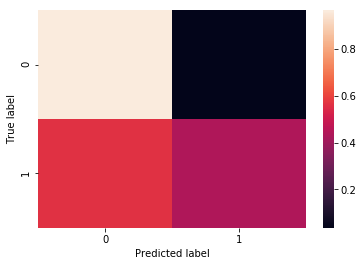

In [24]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, preds)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Tf-idf

In [25]:
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.9, min_df=3, sublinear_tf=True)
tfidf_train = vect.fit_transform(X_train)
tfidf_test = vect.transform(X_test)

In [26]:
model = LogisticRegression(C=30, dual=True)
model.fit(tfidf_train, y_train)
preds = model.predict(tfidf_test)
accuracy = (preds==y_test).mean()
print(accuracy)

0.8592730661696178


# Svm

In [27]:
from sklearn.svm import SVC

vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.9, min_df=3, sublinear_tf=True)
tfidf_train = vect.fit_transform(X_train)
tfidf_test = vect.transform(X_test)

model = SVC(kernel='linear')
model.fit(tfidf_train, y_train)
preds = model.predict(tfidf_test)
accuracy = (preds==y_test).mean()
print(accuracy)

0.8685927306616962


In [28]:
results = confusion_matrix(y_test, preds) 
print ('Confusion Matrix :')
print(results) 

Confusion Matrix :
[[1658   55]
 [ 227  206]]


Text(0.5,15,'Predicted label')

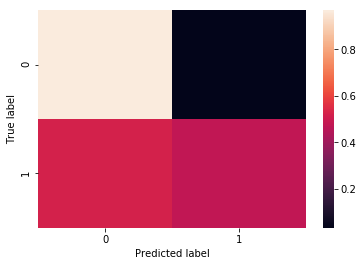

In [29]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, preds)
conf_mat_normalized = results.astype('float') / results.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')